<a href="https://colab.research.google.com/github/David-Carballo/2023w-project-pose/blob/Model-comparative/Yogapostureinceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Data

Import necessary libraries

In [1]:
import sys
import os
import cv2
from google.colab.patches import cv2_imshow
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.utils import list_files
from torchvision.datasets.folder import pil_loader
from torchvision.models import inception_v3
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import make_grid
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from PIL import Image
import zipfile
import albumentations as A
import random
from torchvision.transforms import ToPILImage
import shutil
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cuda'
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

Enable drive storage needed for the weights

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download and extract dataset

In [3]:
# nombre del archivo zip
zip_file = '/content/drive/MyDrive/YogaPostureDataset.zip' #'/content/drive/MyDrive/YogaPostureDataset.zip'
# ruta donde se descomprimirá el archivo
extract_to = '/content/descomprimido'
# descomprimir el archivo
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [4]:
import json

# Save the name of all classes in sanskrit and english
poses_dict = {}

with open('descomprimido/Poses.json') as f:
    data = json.load(f)
    for pose in data['Poses']:
        poses_dict[pose['sanskrit_name']] = pose['english_name']

!rm 'descomprimido/Poses.json'

Define a Dataset loader to preprocess the data (some data augmentation and croping/scaling), and feed the network

In [5]:
class YogaDataset(Dataset):
    def __init__(self, data_dir, transforms = False, train = 0):
        self.data_dir = data_dir
        self.transforms = transforms

        self.train = train
        self.images, self.labels = self.load_data(data_dir)
        self.images = [Image.open(img_path).convert('RGB') for img_path in self.images]

    def __getitem__(self, index):
        img = self.images[index]
        if self.transforms == True:
            if random.random() < 0.75:
                img = self.data_augmentation(img=np.array(img))['image']
        tensor_img = transforms.ToTensor()(img)
        tensor_img = self.image_transform(tensor_img)
        label = self.labels[index]

        return tensor_img, label

    def load_data(self, data_dir):
        images = []
        labels = []
        for i, subdir in enumerate(sorted(os.listdir(data_dir))):
                    subdir_path = os.path.join(data_dir, subdir)
                    if os.path.isdir(subdir_path):
                        for file in sorted(os.listdir(subdir_path)):
                            file_path = os.path.join(subdir_path, file)
                            if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                                images.append(file_path)
                                labels.append(i)


        #Shuffle images
        random.seed(1)

        idx = [x for x in range(0,2756)]
        random.shuffle(idx)

        data = []
        new_labels = []
        for i in idx:
            data.append(images[i])
            new_labels.append(labels[i])

        n = int(len(images) * 0.6)
        aux = int(len(images) * 0.2)
        m = n+aux
        print(idx[n])
        if self.train == 0:
          return data[:n], new_labels[:n]
        elif self.train == 1:
          return data[n:m], new_labels[n:m]
        else:
          return data[m:], new_labels[m:]

    def image_transform(self, tensor):
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        resize = transforms.Resize(299)
        #Check if image size ratio is 1:1
        if tensor.shape[1] != tensor.shape[2]:
            #Calculate difference between X and Y axis
            diff = tensor.shape[1] - tensor.shape[2]
            #Check what dimension needs to be padded either the X (dimension 1 of the tensor, right), or the Y (dimension 3, bottom)
            if diff > 0:
                tensor = F.pad(input=tensor, pad=(0, abs(diff), 0, 0), mode='constant', value=0) #pad(left, right, top, bottom)
            else:
                tensor = F.pad(input=tensor, pad=(0, 0, 0, abs(diff)), mode='constant', value=0)
        tensor = resize(tensor)
        tensor = tensor.reshape(3, 299, 299)
        return tensor

    def data_augmentation(self, img):
        da_transforms = A.Compose([
        A.HorizontalFlip(p = 0.5),
        A.GaussianBlur(p = 0.5),
        A.HueSaturationValue(p = 0.5),
        A.ColorJitter(p = 0.5),
        ])

        # apply data augmentation transforms
        img = da_transforms(image=np.array(img))['image']

        return {'image': img}

    def get_images(self):
      return self.images

    def get_labels(self):
      return self.labels

    def __len__(self):
        return len(self.images)

Split the dataset in 60% train 20% validation and 20% test

In [6]:
#(train = 0 -> Training dataset, 1 -> Validation Dataset, 2 -> Test Dataset)
train_dataset = YogaDataset('descomprimido', transforms = True, train = 0)
val_dataset = YogaDataset('descomprimido', transforms = False, train = 1)
test_dataset = YogaDataset('descomprimido', transforms = False, train = 2)

print('Number of images', len(train_dataset)+len(test_dataset)+len(val_dataset))
print(len(train_dataset),len(test_dataset),len(val_dataset))

2316


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2316
2316
Number of images 2756
1653 552 551


Images seems ok

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


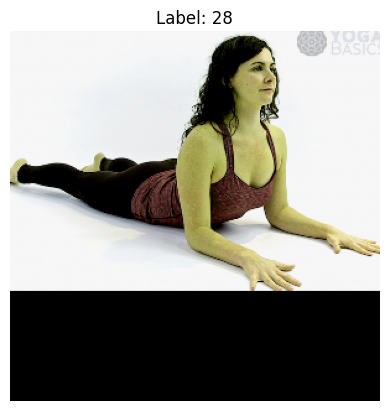

In [7]:
image, label = train_dataset[145]

# convert the tensor image to a PIL Image
to_pil = ToPILImage()
pil_image = to_pil(image)

# plot the image and show its corresponding label
plt.imshow(pil_image)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

#InceptionV3

Define train and test function. Train apply a validation pass every epoch

In [8]:
# Función de entrenamiento
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25, device='cuda'):
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')

        # Cada época tiene una fase de entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Modo de entrenamiento
            else:
                model.eval()   # Modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Iteramos sobre los datos.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Ponemos a cero los gradientes del optimizador
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize solo si estamos en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [9]:
def test(model, test_loader, criterion, device, num_classes=47):
    model.eval()  # set model to evaluation mode
    precision = defaultdict(lambda: 0)
    recall = defaultdict(lambda: 0)
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = defaultdict(lambda: 0)
    class_total = defaultdict(lambda: 0)
    class_true_positive = defaultdict(lambda: 0)
    class_false_positive = defaultdict(lambda: 0)
    class_false_negative = defaultdict(lambda: 0)

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for c in range(num_classes):
                class_correct[c] += ((predicted == labels) & (labels == c)).sum().item()
                class_total[c] += (labels == c).sum().item()
                class_true_positive[c] += ((predicted == labels) & (labels == c)).sum().item()
                class_false_positive[c] += ((predicted == c) & (labels != c)).sum().item()
                class_false_negative[c] += ((predicted != c) & (labels == c)).sum().item()
        # Calculate precision and recall by class
    for c in range(num_classes):
        if class_correct[c] + class_false_positive[c] == 0:
            precision[c] = 0
        else:
            precision[c] = class_true_positive[c] / (class_correct[c] + class_false_positive[c])
        if class_correct[c] + class_false_negative[c] == 0:
            recall[c] = 0
        else:
            recall[c] = class_true_positive[c] / (class_correct[c] + class_false_negative[c])
    print('Precision by class:', dict(precision))
    print('Recall by class:', dict(recall))

    # Print test statistics
    print('Test Loss: %.3f, Accuracy: %.3f' %
          (running_loss / len(test_loader), 100 * correct / total))

    return 100 * correct / total

Instance Inception model, crop last layers and add 47 fully connected neurons at the end (num classes == num neurons)

In [10]:
# Crear el modelo
model = inception_v3(pretrained=True)
model.aux_logits=False

# Personalizar las capas de clasificación
model.fc = nn.Sequential(
    nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Linear(in_features=2048, out_features=50, bias=True),
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=50, out_features=47, bias=True),
    nn.LogSoftmax(dim=1)
)

# Definir el criterio, el optimizador y el scheduler
criterion = nn.NLLLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 63.3MB/s] 


In [12]:
# Entrenar el modelo
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}


model = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10, device=device)

Epoch 0/9
train Loss: 3.1290 Acc: 0.2129
val Loss: 2.4445 Acc: 0.3358
Epoch 1/9
train Loss: 2.1644 Acc: 0.4392
val Loss: 1.7098 Acc: 0.5372
Epoch 2/9
train Loss: 1.5601 Acc: 0.5747
val Loss: 1.5312 Acc: 0.6025
Epoch 3/9
train Loss: 1.3056 Acc: 0.6449
val Loss: 1.4134 Acc: 0.6279
Epoch 4/9
train Loss: 1.2771 Acc: 0.6600
val Loss: 1.1547 Acc: 0.6951
Epoch 5/9
train Loss: 1.0476 Acc: 0.7241
val Loss: 1.0145 Acc: 0.7169
Epoch 6/9
train Loss: 0.9092 Acc: 0.7508
val Loss: 1.1991 Acc: 0.7114
Epoch 7/9
train Loss: 0.6553 Acc: 0.8179
val Loss: 0.6665 Acc: 0.8240
Epoch 8/9
train Loss: 0.4774 Acc: 0.8681
val Loss: 0.6129 Acc: 0.8348
Epoch 9/9
train Loss: 0.4566 Acc: 0.8724
val Loss: 0.5892 Acc: 0.8421


In [13]:
test(model, test_dataloader, criterion, device)

Precision by class: {0: 0.7368421052631579, 1: 0.8421052631578947, 2: 0, 3: 0.9166666666666666, 4: 1.0, 5: 0.84, 6: 1.0, 7: 1.0, 8: 1.0, 9: 0.9285714285714286, 10: 0.8571428571428571, 11: 1.0, 12: 0.8235294117647058, 13: 0.9230769230769231, 14: 1.0, 15: 0.9333333333333333, 16: 0.8181818181818182, 17: 0.9090909090909091, 18: 0.75, 19: 0.75, 20: 0.75, 21: 0.8, 22: 0.9375, 23: 1.0, 24: 0.7, 25: 0.5555555555555556, 26: 1.0, 27: 0.8888888888888888, 28: 0.8, 29: 0.8333333333333334, 30: 0.9166666666666666, 31: 0.8333333333333334, 32: 0, 33: 0.5, 34: 1.0, 35: 0.875, 36: 1.0, 37: 1.0, 38: 0.875, 39: 1.0, 40: 1.0, 41: 0.9444444444444444, 42: 0.782608695652174, 43: 0.6470588235294118, 44: 1.0, 45: 0.9090909090909091, 46: 1.0}
Recall by class: {0: 1.0, 1: 0.9411764705882353, 2: 0.0, 3: 0.9166666666666666, 4: 0.7777777777777778, 5: 0.9545454545454546, 6: 0.5, 7: 0.5, 8: 1.0, 9: 0.8125, 10: 1.0, 11: 0.8571428571428571, 12: 0.875, 13: 0.9230769230769231, 14: 1.0, 15: 1.0, 16: 0.9, 17: 0.9090909090909

86.95652173913044